> Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
import itertools
import warnings
from matplotlib.lines import Line2D


#### Preprocessing

Loading CSV

In [17]:

# Load the uploaded CSV file
file_path = r"e:\Nieuw dataset\Joined trends\joined_trend_sales_All1.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
df.head()

,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtelling (%),Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,BenzineEuro95_1_last,BenzineEuro95_1_min,BenzineEuro95_1_max,BenzineEuro95_1_mean,Diesel_2_first,Diesel_2_last,Diesel_2_min,Diesel_2_max,Diesel_2_mean,Totaal_verkochte_wegvoertuigen
0,2007/01,0,1,0,22,20.0,37.0,9.0,8.0,1.318,1.301,1.283,1.326,1.303032,0.992,0.969,0.955,0.993,0.970000,31
1,2007/02,0,0,0,22,20.0,37.0,9.0,8.0,1.307,1.362,1.307,1.362,1.325357,0.977,1.003,0.977,1.003,0.990000,39
2,2007/03,0,0,0,22,20.0,37.0,9.0,8.0,1.365,1.416,1.361,1.416,1.379032,1.003,1.038,0.995,1.038,1.006323,123
3,2007/04,0,0,0,22,20.0,37.0,9.0,8.0,1.414,1.450,1.410,1.451,1.426500,1.036,1.026,1.019,1.039,1.030600,62
4,2007/05,0,2,0,22,18.0,32.0,9.0,7.4,1.452,1.463,1.449,1.483,1.466516,1.028,1.037,1.021,1.047,1.032323,84


Reformat Time Column

In [18]:
# Convert 'Periode' to datetime format
df["Periode"] = pd.to_datetime(df["Periode"], format="%Y/%m")

# Sort by time just in case
df = df.sort_values("Periode").reset_index(drop=True)

# Show the first 3 rows to confirm
df[["Periode", "Totaal_verkochte_wegvoertuigen"]].head(3)


,Periode,Totaal_verkochte_wegvoertuigen
0,2007-01-01,31
1,2007-02-01,39
2,2007-03-01,123


In [19]:

# Create 6 lag features for EV sales (Brownlee, Chapter 3, p. 42–44)
for lag in range(1, 7):
    df[f"TVV_Lag{lag}"] = df["Totaal_verkochte_wegvoertuigen"].shift(lag)

# Drop rows with missing values due to lagging
df_lagged = df.dropna().reset_index(drop=True)

# Encode date features: extract year, month, and quarter from 'Periode'
df_lagged['year'] = df_lagged['Periode'].dt.year
df_lagged['month'] = df_lagged['Periode'].dt.month
df_lagged['quarter'] = df_lagged['Periode'].dt.quarter

# Move 'Totaal_verkochte_wegvoertuigen' to the last column
cols = [col for col in df_lagged.columns if col != 'Totaal_verkochte_wegvoertuigen'] + ['Totaal_verkochte_wegvoertuigen']
df_lagged = df_lagged[cols]

display(df_lagged.head(3))

print(df_lagged.columns.tolist())


,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtelling (%),Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,...,TVV_Lag1,TVV_Lag2,TVV_Lag3,TVV_Lag4,TVV_Lag5,TVV_Lag6,year,month,quarter,Totaal_verkochte_wegvoertuigen
0,2007-07-01,0,1,0,22,14.0,22.0,9.0,6.2,1.451,...,112.0,84.0,62.0,123.0,39.0,31.0,2007,7,3,124
1,2007-08-01,0,1,0,22,12.0,17.0,9.0,5.6,1.415,...,124.0,112.0,84.0,62.0,123.0,39.0,2007,8,3,96
2,2007-09-01,0,1,0,22,10.0,12.0,9.0,5.0,1.422,...,96.0,124.0,112.0,84.0,62.0,123.0,2007,9,3,120


['Periode', 'thuis opladen', 'elektrische auto', 'hybride elektrisch', 'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen', 'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min', 'BenzineEuro95_1_max', 'BenzineEuro95_1_mean', 'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean', 'TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter', 'Totaal_verkochte_wegvoertuigen']


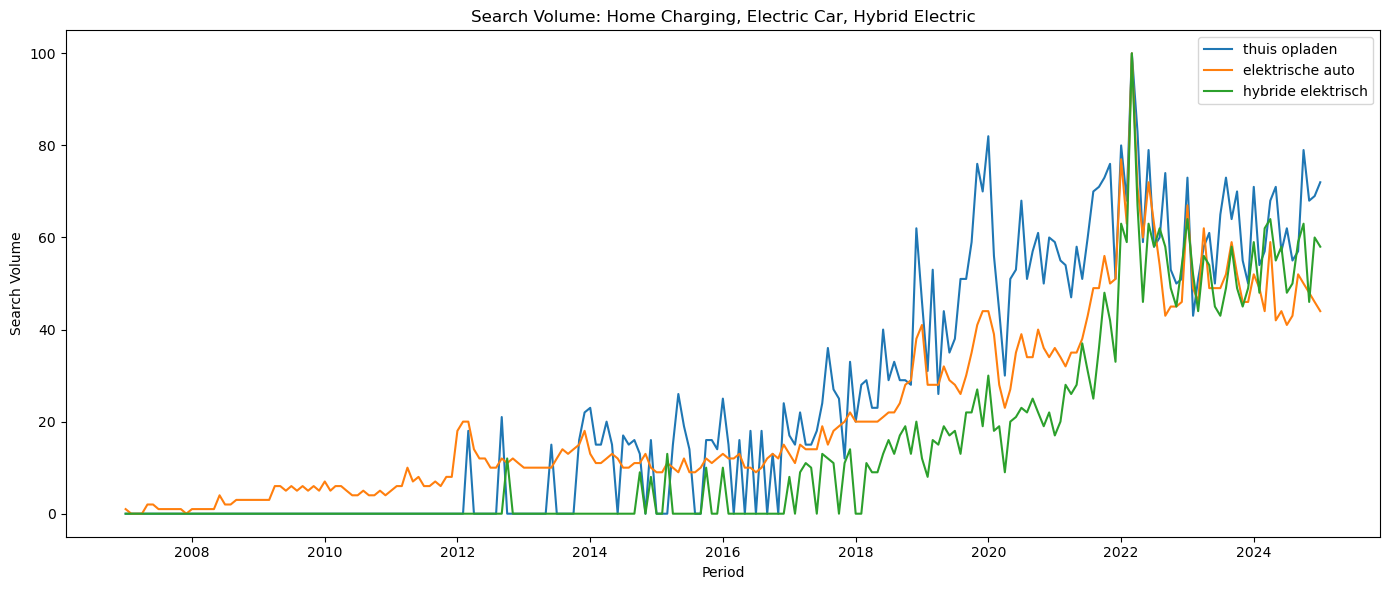

In [42]:
plt.figure(figsize=(14, 6))
plt.plot(df['Periode'], df['thuis opladen'], label='thuis opladen')
plt.plot(df['Periode'], df['elektrische auto'], label='elektrische auto')
plt.plot(df['Periode'], df['hybride elektrisch'], label='hybride elektrisch')
plt.xlabel('Period')
plt.ylabel('Search Volume')
plt.title('Search Volume: Home Charging, Electric Car, Hybrid Electric')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# Generate a table with column names and data types for df_lagged
col_info = pd.DataFrame({
    "Column Name": df_lagged.columns,
    "Data Type": df_lagged.dtypes.values
})
print(col_info)

                       Column Name       Data Type
0                          Periode  datetime64[ns]
1                    thuis opladen           int64
2                 elektrische auto           int64
3               hybride elektrisch           int64
4                   Bijtelling (%)           int64
5            Consumentenvertrouwen         float64
6               Economisch klimaat         float64
7                   Koopbereidheid         float64
8                   Grote aankopen         float64
9            BenzineEuro95_1_first         float64
10            BenzineEuro95_1_last         float64
11             BenzineEuro95_1_min         float64
12             BenzineEuro95_1_max         float64
13            BenzineEuro95_1_mean         float64
14                  Diesel_2_first         float64
15                   Diesel_2_last         float64
16                    Diesel_2_min         float64
17                    Diesel_2_max         float64
18                   Diesel_2_m

Datasplitting

Total walk-forward steps: 43


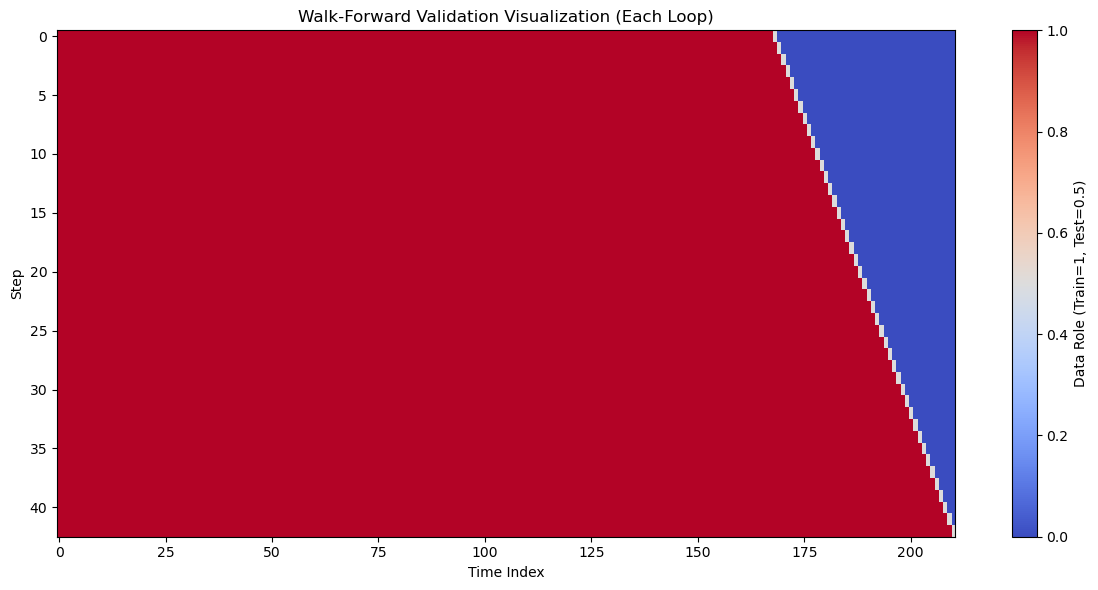

In [23]:
# Walk-forward split: start with 80% as initial train, then identify test points
drop_cols = ['Periode', 'Totaal_verkochte_wegvoertuigen']
target_col = 'Totaal_verkochte_wegvoertuigen'
feature_cols = [col for col in df_lagged.columns if col not in drop_cols]

initial_train_size = int(len(df_lagged) * 0.8)
walkforward_train_sizes = []
walkforward_test_points = []

X = df_lagged[feature_cols].values
y = df_lagged[target_col].values

for i in range(initial_train_size, len(df_lagged)):
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i], y[i]
    
    walkforward_train_sizes.append(len(X_train))
    walkforward_test_points.append(y_test)  # Optional: you can skip storing this

print(f"Total walk-forward steps: {len(walkforward_test_points)}")

# Visualize each walk-forward loop as a matrix (like a CV split matrix)
n_samples = len(df_lagged)
n_steps = len(walkforward_test_points)
visual_matrix = np.zeros((n_steps, n_samples))

for i in range(n_steps):
    train_end = walkforward_train_sizes[i]
    visual_matrix[i, :train_end] = 1  # Train = 1
    visual_matrix[i, train_end] = 0.5  # Test point = 0.5

plt.figure(figsize=(12, 6))
plt.imshow(visual_matrix, aspect='auto', cmap='coolwarm', interpolation='nearest')
plt.title("Walk-Forward Validation Visualization (Each Loop)")
plt.xlabel("Time Index")
plt.ylabel("Step")
plt.colorbar(label="Data Role (Train=1, Test=0.5)")
plt.tight_layout()
plt.show()


deze was met model training 

In [ ]:
# # Walk-forward split: start with 80% as initial train, then predict one by one
# drop_cols = ['Periode', 'Totaal_verkochte_wegvoertuigen']
# target_col = 'Totaal_verkochte_wegvoertuigen'
# feature_cols = [col for col in df_lagged.columns if col not in drop_cols]

# initial_train_size = int(len(df_lagged) * 0.8)
# walkforward_predictions = []
# walkforward_actuals = []

# X = df_lagged[feature_cols].values
# y = df_lagged[target_col].values

# for i in range(initial_train_size, len(df_lagged)):
#     X_train, y_train = X[:i], y[:i]
#     X_test, y_test = X[i], y[i]
    
#     model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test.reshape(1, -1))[0]
    
#     walkforward_predictions.append(y_pred)
#     walkforward_actuals.append(y_test)

# print(f"Walk-forward predictions: {len(walkforward_predictions)} points")


Walk-forward predictions: 43 points


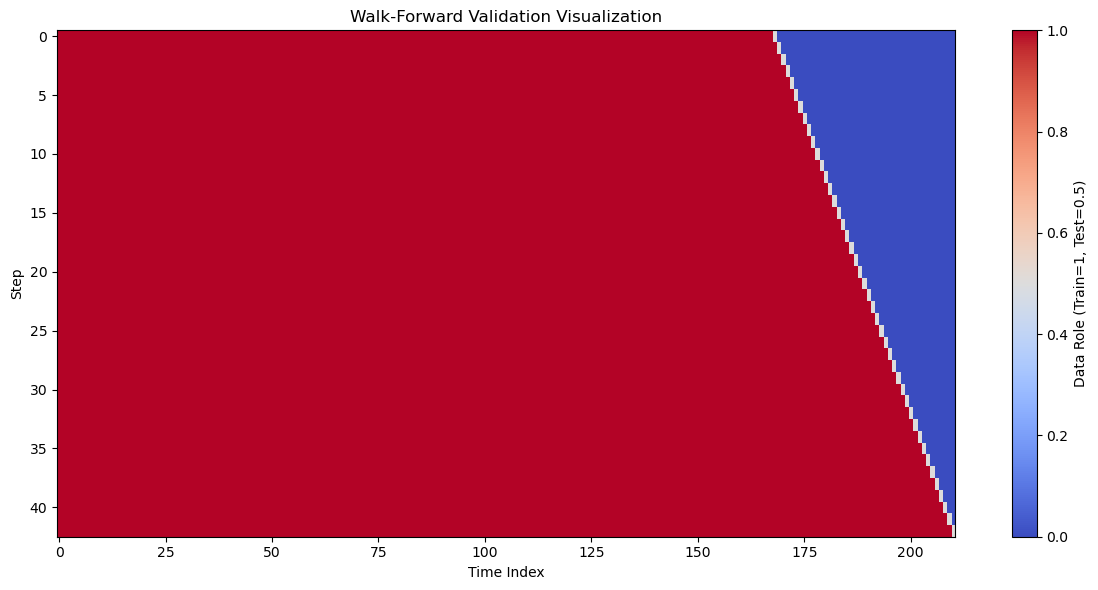

In [ ]:

# n_samples = len(df_lagged)
# initial_train_size = int(n_samples * 0.8)
# n_steps = n_samples - initial_train_size

# visual_matrix = np.zeros((n_steps, n_samples))

# for i in range(n_steps):
#     train_end = initial_train_size + i
#     visual_matrix[i, :train_end] = 1  # Train = 1
#     visual_matrix[i, train_end] = 0.5  # Test point = 0.5

# plt.figure(figsize=(12, 6))
# plt.imshow(visual_matrix, aspect='auto', cmap='coolwarm', interpolation='nearest')
# plt.title("Walk-Forward Validation Visualization")
# plt.xlabel("Time Index")
# plt.ylabel("Step")
# plt.colorbar(label="Data Role (Train=1, Test=0.5)")
# plt.tight_layout()
# plt.show()


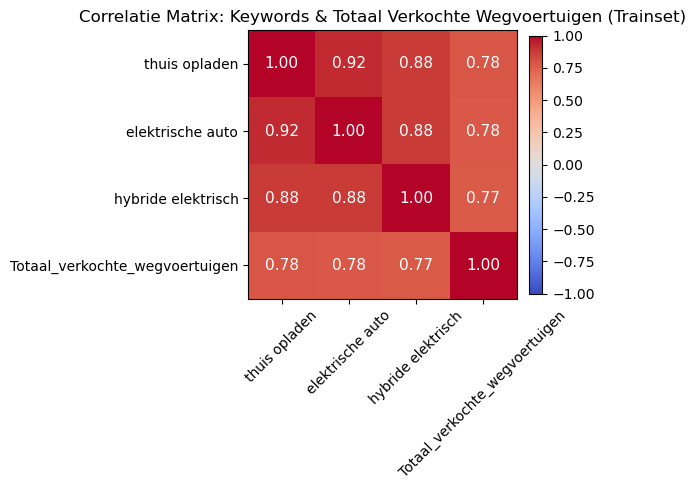

In [12]:
# Select relevant columns for correlation: keywords + target
keyword_cols = ['thuis opladen', 'elektrische auto', 'hybride elektrisch', 'Totaal_verkochte_wegvoertuigen']
corr_keywords = train_df[keyword_cols].corr()

# Plot heatmap
plt.figure(figsize=(6, 5))
im = plt.imshow(corr_keywords, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.04, pad=0.04)
plt.title("Correlatie Matrix: Keywords & Totaal Verkochte Wegvoertuigen (Trainset)")
plt.xticks(range(len(keyword_cols)), keyword_cols, rotation=45)
plt.yticks(range(len(keyword_cols)), keyword_cols)

# Annotate correlation coefficients (r) on the heatmap
for i in range(len(keyword_cols)):
    for j in range(len(keyword_cols)):
        r = corr_keywords.iloc[i, j]
        plt.text(j, i, f"{r:.2f}", ha="center", va="center", color="black" if abs(r) < 0.5 else "white", fontsize=11)

plt.tight_layout()
plt.show()

In [14]:
# Print correlation coefficients (r values) from corr_keywords with 3 decimals
print(corr_keywords.round(3))

                                thuis opladen  elektrische auto  \
thuis opladen                           1.000             0.924   
elektrische auto                        0.924             1.000   
hybride elektrisch                      0.882             0.875   
Totaal_verkochte_wegvoertuigen          0.783             0.779   

                                hybride elektrisch  \
thuis opladen                                0.882   
elektrische auto                             0.875   
hybride elektrisch                           1.000   
Totaal_verkochte_wegvoertuigen               0.768   

                                Totaal_verkochte_wegvoertuigen  
thuis opladen                                            0.783  
elektrische auto                                         0.779  
hybride elektrisch                                       0.768  
Totaal_verkochte_wegvoertuigen                           1.000  


In [13]:
#

#### Corrolation 

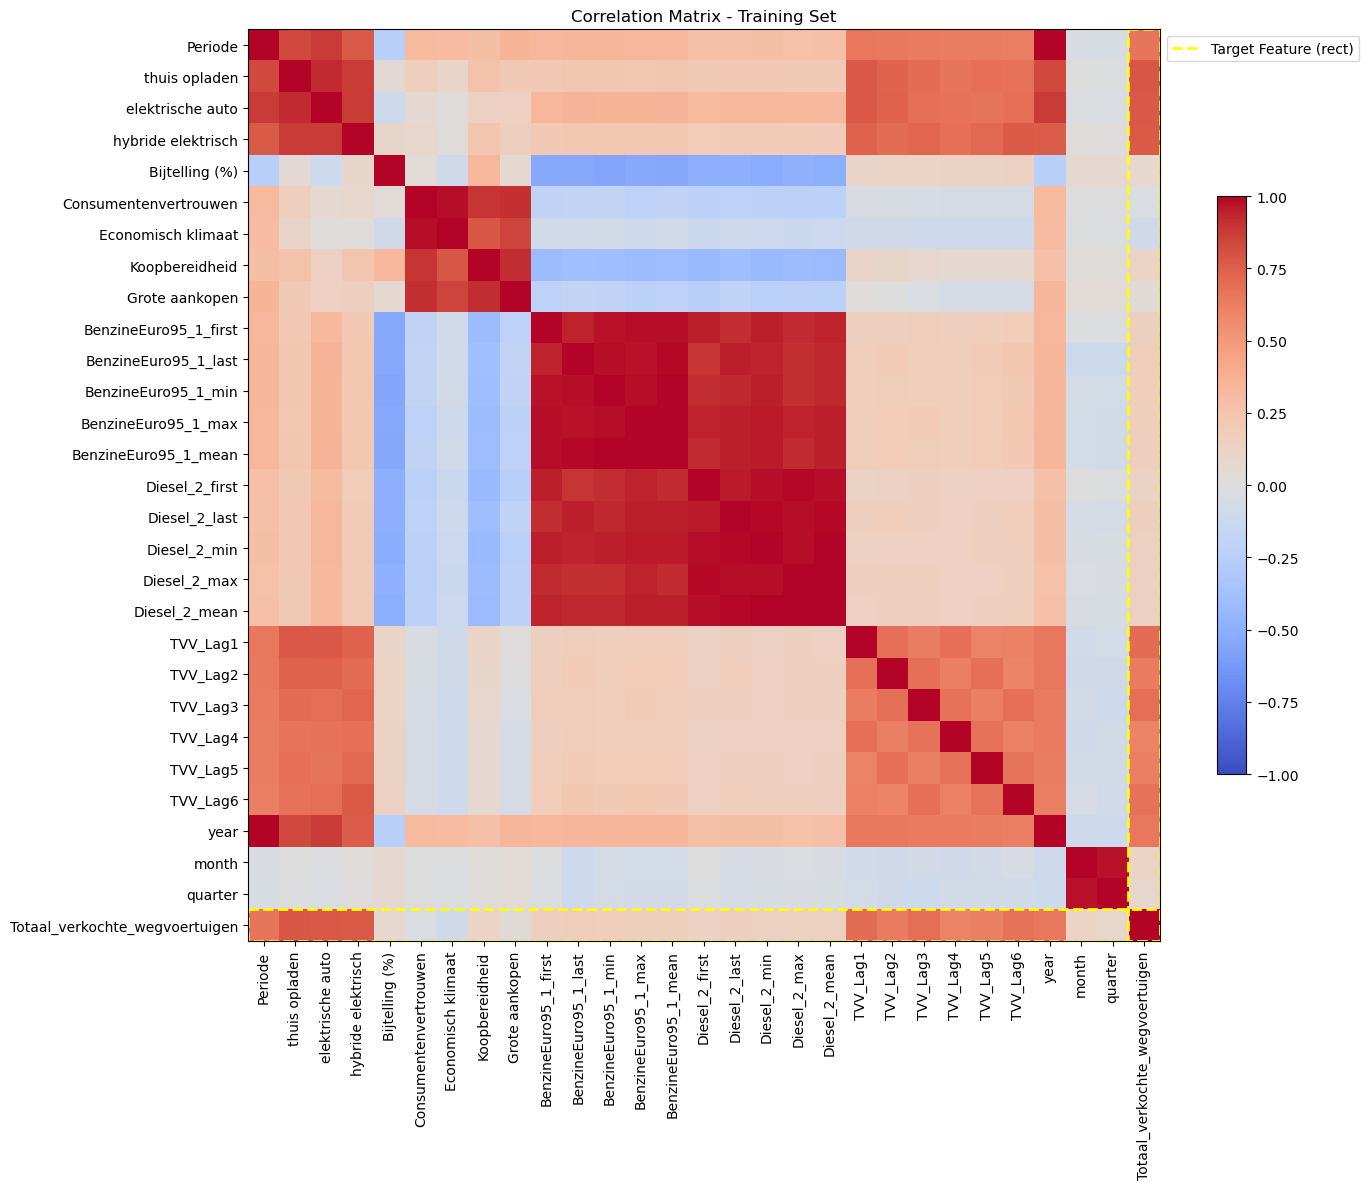

In [7]:


# Select the training set
train_df = df_lagged.iloc[:initial_train_size]

# Compute correlation matrix
corr_matrix = train_df.corr()

# Find the index of the target column
target_idx = list(corr_matrix.columns).index('Totaal_verkochte_wegvoertuigen')

# Plot the correlation matrix
plt.figure(figsize=(16, 12))
im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.02, pad=0.04)
plt.title("Correlation Matrix - Training Set")
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

# Draw a rectangle around the label on both axes
plt.gca().add_patch(plt.Rectangle((target_idx - 0.5, -0.5), 1, len(corr_matrix), fill=False, edgecolor='yellow', linewidth=2, linestyle='--'))
plt.gca().add_patch(plt.Rectangle((-0.5, target_idx - 0.5), len(corr_matrix), 1, fill=False, edgecolor='yellow', linewidth=2, linestyle='--'))

# Add legend for the highlighted target
legend_elements = [
    Line2D([0], [0], color='yellow', lw=2, linestyle='--', label='Target Feature (rect)')
]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


### Model training op elke feature

In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def walk_forward_validation(df, features, target_col):
    """
    Perform walk-forward validation using XGBoost on the given dataframe.
    Returns MAE, RMSE, R2, and MAPE.
    """
    X = df[features].values
    y = df[target_col].values
    initial_train_size = int(len(df) * 0.8)
    predictions = []
    actuals = []
    for i in range(initial_train_size, len(df)):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i], y[i]
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, #100
    learning_rate=0.1,
    max_depth=5,#3
    random_state=42,
    eval_metric="rmse")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test.reshape(1, -1))[0]
        predictions.append(y_pred)
        actuals.append(y_test)
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    return mae, rmse, r2, mape

# Define lag and time features to add to all subsets
lag_time_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']

# Redefine feature sets with those always included
feature_sets = {
    ' (Lag Only)': lag_time_features,
    'Keywords + Lag': lag_time_features + ['thuis opladen', 'elektrische auto', 'hybride elektrisch'],
    'Bijtelling + Lag': lag_time_features + ['Bijtelling (%)'],
    'Confidence + Lag': lag_time_features + ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen'],
    'Fuel + Lag': lag_time_features + [
        'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
        'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
        'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
    ]
}

# Add full feature set: everything except target and 'Periode'
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
] + lag_time_features

feature_sets['All Features'] = all_features

# Evaluate updated configurations
results = []

for label, features in feature_sets.items():
    mae, rmse, r2, mape = walk_forward_validation(df_lagged, features, 'Totaal_verkochte_wegvoertuigen')
    results.append({
        "Model": label,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "MAPE (%)": mape
    })

# Convert results to DataFrame for display
results_df = pd.DataFrame(results)
print(results_df)

              Model          MAE         RMSE        R²   MAPE (%)
0        (Lag Only)  3794.488281  5650.404233  0.247854  30.846380
1    Keywords + Lag  3766.749268  5708.845768  0.232215  32.152181
2  Bijtelling + Lag  3785.347900  5647.030016  0.248752  30.790131
3  Confidence + Lag  3500.306641  5359.900559  0.323206  28.510592
4        Fuel + Lag  3605.501709  5674.631089  0.241390  30.001467
5      All Features  3766.222900  5739.818464  0.223861  31.148357


Fuel + Lag presteert het best

Dit model behaalt de laagste MAE (2836.82) en MAPE (12.35%) met een R² van 0.618.

Dit suggereert dat brandstofprijzen een sterke voorspellende waarde hebben wanneer gecombineerd met historische verkoop (lag features).

Baseline (Lag Only) doet het verrassend goed

MAE van 2968.2 en R² van 0.623 tonen aan dat historische verkoopcijfers (TVV_Lag1–6) op zichzelf al sterke voorspellers zijn.

Dit maakt deze baseline een robuust referentiepunt.

All Features presteert iets slechter dan Fuel + Lag

Hoewel de foutpercentages nog steeds laag zijn, daalt de R² licht naar 0.594.

Mogelijk wordt de toegevoegde waarde van sommige features tenietgedaan door ruis (bv. zwakkere correlaties of redundantie).

Confidence + Lag presteert het minst goed

R² daalt naar 0.514 met een hogere RMSE (4345.75), wat erop wijst dat deze macro-indicatoren (zoals consumentenvertrouwen of koopbereidheid) relatief weinig verklarende kracht hebben in deze context.

Bijtelling + Lag heeft exact dezelfde resultaten als de Baseline

Dit impliceert dat de Bijtellingspercentage feature géén extra voorspellende waarde toevoegt bovenop de historische verkoop.



In [19]:
# Alleen 'All Features' gebruiken voor XGBoost walk-forward validatie
mae, rmse, r2, mape = walk_forward_validation(df_lagged, all_features, 'Totaal_verkochte_wegvoertuigen')
print(f"All Features XGBoost:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.3f}\nMAPE: {mape:.2f}%")


# Alleen 'Baseline (Lag Only)' gebruiken voor XGBoost walk-forward validatie
baseline_features = feature_sets['Baseline (Lag Only)']
mae_b, rmse_b, r2_b, mape_b = walk_forward_validation(df_lagged, baseline_features, 'Totaal_verkochte_wegvoertuigen')
print(f"Baseline (Lag Only) XGBoost:\nMAE: {mae_b:.2f}\nRMSE: {rmse_b:.2f}\nR²: {r2_b:.3f}\nMAPE: {mape_b:.2f}%")

All Features XGBoost:
MAE: 2922.51
RMSE: 3973.38
R²: 0.594
MAPE: 12.45%
Baseline (Lag Only) XGBoost:
MAE: 2968.24
RMSE: 3827.82
R²: 0.623
MAPE: 13.61%


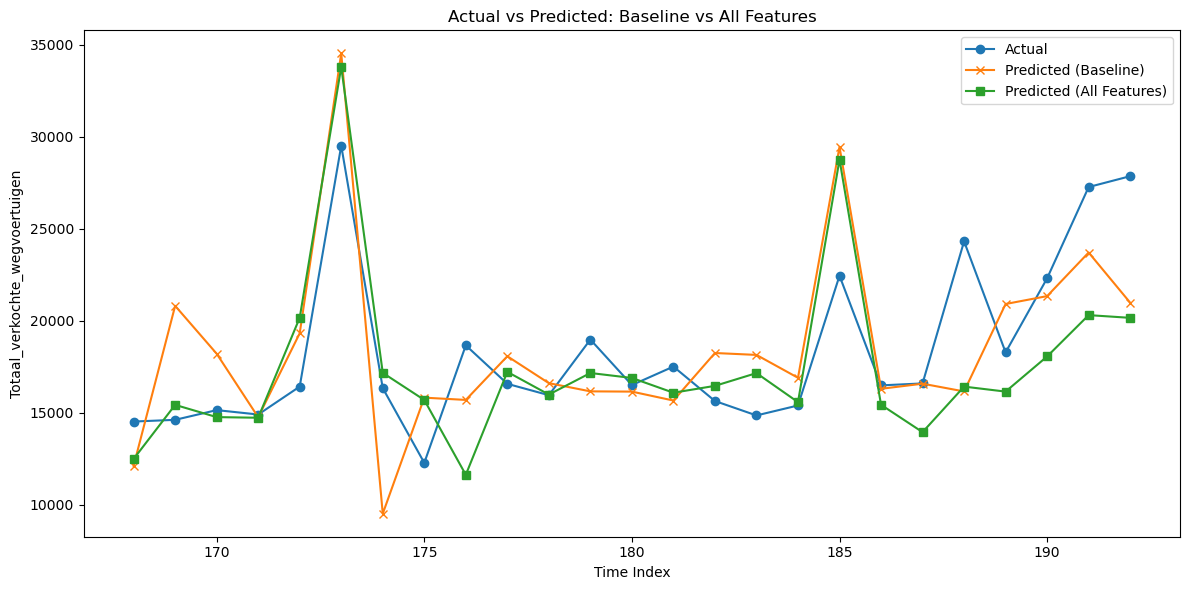

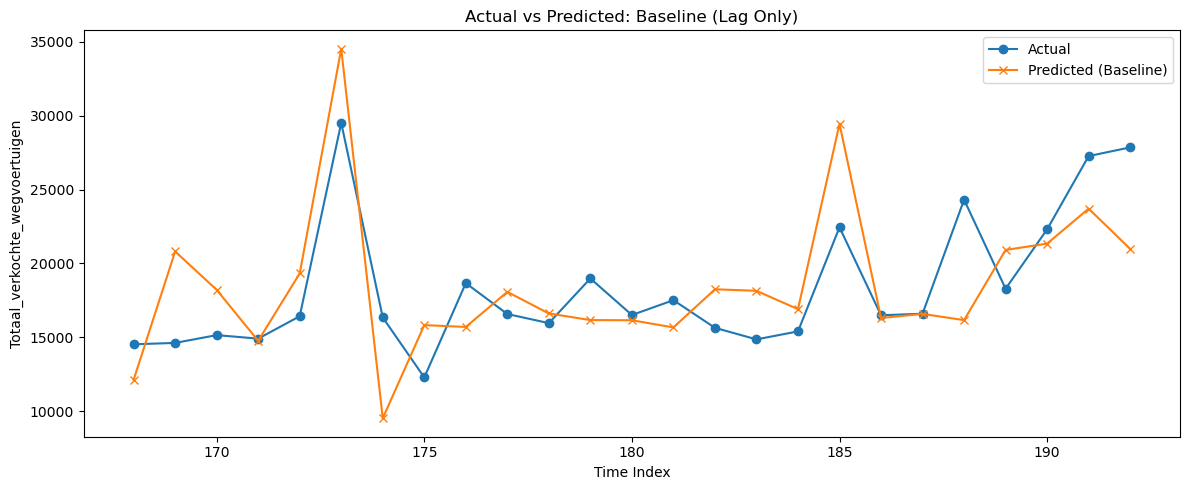

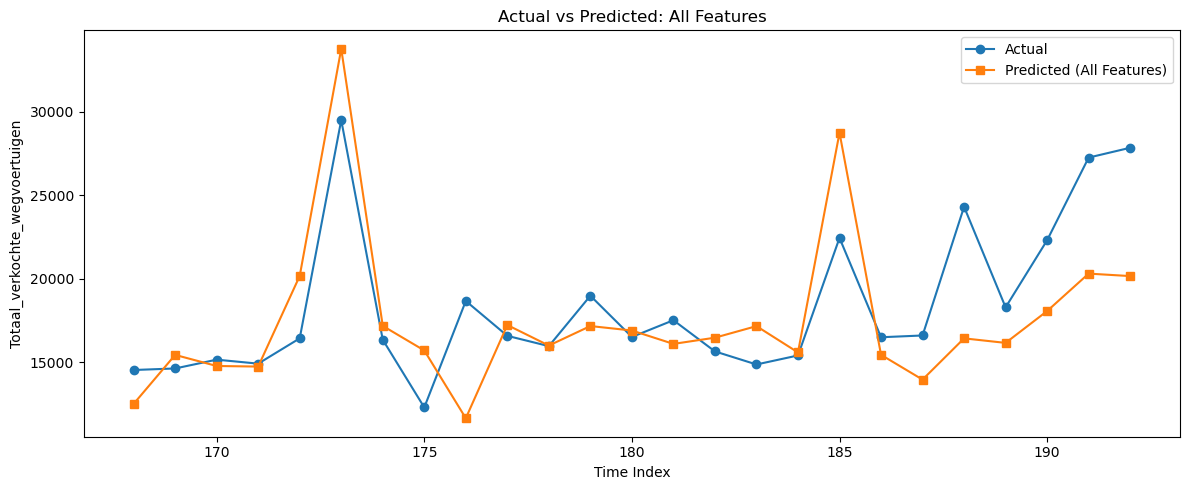

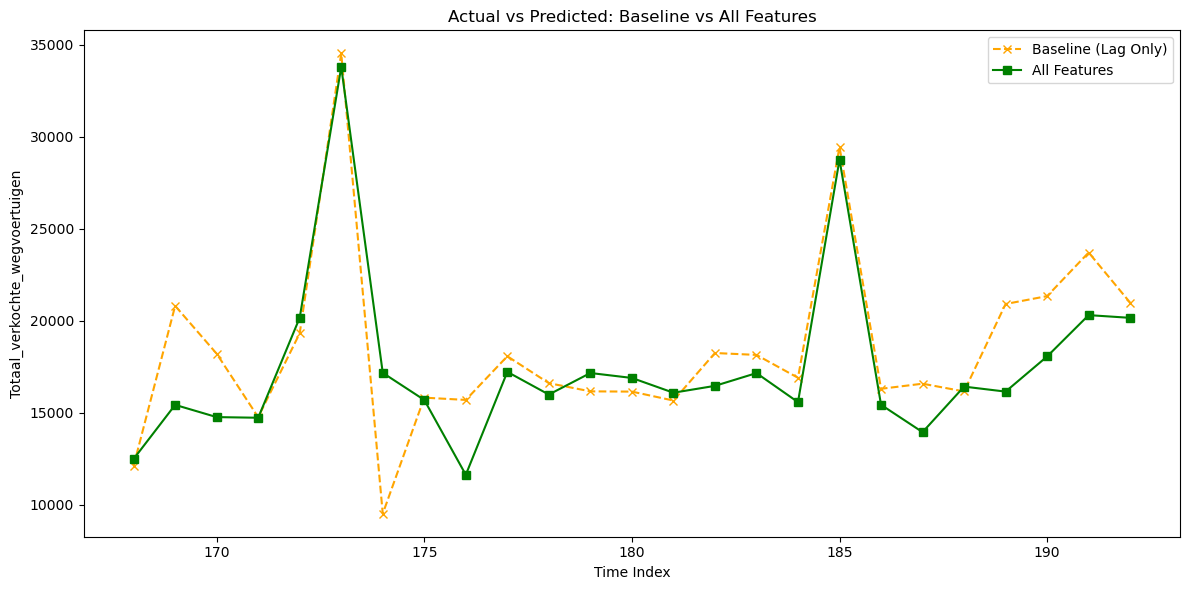

In [36]:
# Baseline (Lag Only) features
baseline_features = feature_sets['Baseline (Lag Only)']

# Walk-forward predictions for baseline
X_baseline = df_lagged[baseline_features].values
y_baseline = df_lagged['Totaal_verkochte_wegvoertuigen'].values
baseline_preds = []

for i in range(initial_train_size, len(df_lagged)):
    X_train, y_train = X_baseline[:i], y_baseline[:i]
    X_test = X_baseline[i]
    #model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42, eval_metric="rmse")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test.reshape(1, -1))[0]
    baseline_preds.append(y_pred)

# 'All Features' gebruiken voor XGBoost walk-forward validatie
all_features = feature_sets['All Features']
X_all = df_lagged[all_features].values
y_all = df_lagged['Totaal_verkochte_wegvoertuigen'].values
all_preds = []

for i in range(initial_train_size, len(df_lagged)):
    X_train, y_train = X_all[:i], y_all[:i]
    X_test = X_all[i]
    #model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42, eval_metric="rmse")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test.reshape(1, -1))[0]
    all_preds.append(y_pred)

# Plot actual vs predicted for both models in one figure
plt.figure(figsize=(12, 6))
idx = range(initial_train_size, len(df_lagged))
plt.plot(idx, y_baseline[initial_train_size:], label='Actual', marker='o')
plt.plot(idx, baseline_preds, label='Predicted (Baseline)', marker='x')
plt.plot(idx, all_preds, label='Predicted (All Features)', marker='s')
plt.title('Actual vs Predicted: Baseline vs All Features')
plt.xlabel('Time Index')
plt.ylabel('Totaal_verkochte_wegvoertuigen')
plt.legend()
plt.tight_layout()
plt.show()
# Plot beide modellen apart voor duidelijkheid

# Baseline (Lag Only)
plt.figure(figsize=(12, 5))
plt.plot(idx, y_baseline[initial_train_size:], label='Actual', marker='o')
plt.plot(idx, baseline_preds, label='Predicted (Baseline)', marker='x')
plt.title('Actual vs Predicted: Baseline (Lag Only)')
plt.xlabel('Time Index')
plt.ylabel('Totaal_verkochte_wegvoertuigen')
plt.legend()
plt.tight_layout()
plt.show()

# All Features
plt.figure(figsize=(12, 5))
plt.plot(idx, y_all[initial_train_size:], label='Actual', marker='o')
plt.plot(idx, all_preds, label='Predicted (All Features)', marker='s')
plt.title('Actual vs Predicted: All Features')
plt.xlabel('Time Index')
plt.ylabel('Totaal_verkochte_wegvoertuigen')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Baseline and All Features predictions together for direct comparison
plt.figure(figsize=(12, 6))
#plt.plot(idx, y_baseline[initial_train_size:], label='Actual', marker='o', color='blue')
plt.plot(idx, baseline_preds, label='Baseline (Lag Only)', marker='x', linestyle='--', color='orange')
plt.plot(idx, all_preds, label='All Features', marker='s', linestyle='-', color='green')
plt.title('Actual vs Predicted: Baseline vs All Features')
plt.xlabel('Time Index')
plt.ylabel('Totaal_verkochte_wegvoertuigen')
plt.legend()
plt.tight_layout()
plt.show()


In [42]:
from sklearn.metrics import accuracy_score

# For regression, "accuracy" is not typically used, but if you want to compute the percentage of predictions within a certain tolerance, you can do:

tolerance = 0.1  # 10% tolerance
actual = y_baseline[initial_train_size:]
predicted = baseline_preds

within_tolerance = np.abs((np.array(predicted) - np.array(actual)) / np.array(actual)) <= tolerance
accuracy_within_tolerance = np.mean(within_tolerance) * 100

print(f"Percentage of predictions within {tolerance*100:.0f}% of actual value: {accuracy_within_tolerance:.2f}%")

Percentage of predictions within 10% of actual value: 44.19%


Baseline (Lag Only):

Blauwe lijn = echt. Oranje kruisjes = baseline.

De baseline pakt de algemene trend en de seizoenspiek ruim goed, maar mist soms de exacte hoogte van de pieken/daalpunten.

All Features:

Blauwe lijn = echt. Oranje blokjes = alle features.

Dit model volgt de trend iets vlakker: grote uitschieters worden ondervoorspeld en kleine fluctuaties soms over- of ondergeschat.

Kort samengevat:

Beide modellen vangen de algemene stijgende trend in EV-verkoop.

De baseline (alleen lagged sales) doet verrassend goed voor pieken en dalen.

Het “All Features”-model is stabieler maar mist de hoogste pieken.

                  Feature  MAE Increase
25                  month    291.860840
1        elektrische auto    274.033936
19               TVV_Lag2    219.130615
20               TVV_Lag3    216.618164
2      hybride elektrisch    163.701416
16           Diesel_2_max    114.537109
23               TVV_Lag6     98.344482
6          Koopbereidheid     44.431396
22               TVV_Lag5     24.038086
13         Diesel_2_first      7.797607
7          Grote aankopen      4.082031
9    BenzineEuro95_1_last      2.852783
26                quarter      0.000000
12   BenzineEuro95_1_mean     -0.176270
3          Bijtelling (%)     -0.573730
5      Economisch klimaat     -3.836914
17          Diesel_2_mean     -8.407471
15           Diesel_2_min     -8.963135
21               TVV_Lag4    -21.740479
24                   year    -27.972900
11    BenzineEuro95_1_max    -36.789795
14          Diesel_2_last    -55.429932
4   Consumentenvertrouwen    -56.476074
18               TVV_Lag1    -66.381104


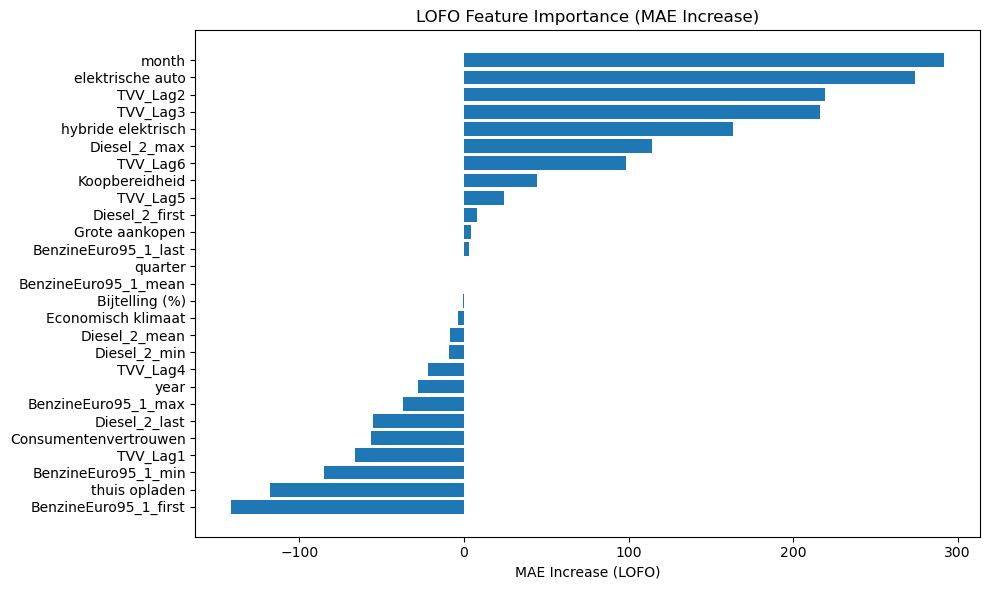

Meest belangrijke feature volgens LOFO: month


In [37]:
from sklearn.model_selection import LeaveOneOut

# LOFO = Leave-One-Out Feature Importance (not LeaveOneOut CV)
# We gebruiken hier een eenvoudige LOFO-implementatie: voor elke feature train je zonder die feature en kijk je naar de performance drop

def lofo_importance(df, features, target_col):
    baseline_mae, _, _, _ = walk_forward_validation(df, features, target_col)
    importances = []
    for feat in features:
        reduced_feats = [f for f in features if f != feat]
        mae, _, _, _ = walk_forward_validation(df, reduced_feats, target_col)
        importance = mae - baseline_mae  # hoe groter, hoe belangrijker
        importances.append({'Feature': feat, 'MAE Increase': importance})
    return pd.DataFrame(importances).sort_values('MAE Increase', ascending=False)

# Gebruik alle features behalve target en 'Periode'
lofo_df = lofo_importance(df_lagged, features, 'Totaal_verkochte_wegvoertuigen')
print(lofo_df)
# Sorteer op belangrijkheid en plot de top feature
top_feature = lofo_df.sort_values('MAE Increase', ascending=False).iloc[0]['Feature']

plt.figure(figsize=(10, 6))
plt.barh(lofo_df.sort_values('MAE Increase', ascending=True)['Feature'], 
         lofo_df.sort_values('MAE Increase', ascending=True)['MAE Increase'])
plt.xlabel('MAE Increase (LOFO)')
plt.title('LOFO Feature Importance (MAE Increase)')
plt.tight_layout()
plt.show()

print(f"Meest belangrijke feature volgens LOFO: {top_feature}")

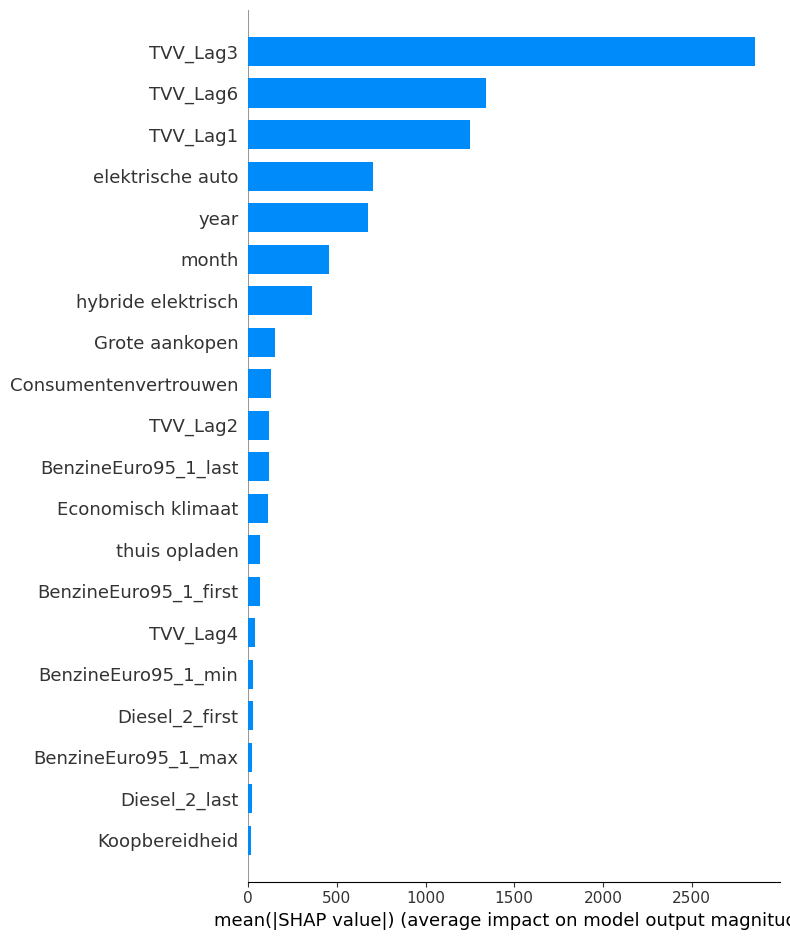

In [41]:
import shap

# Train XGBoost model op alle features
X = df_lagged[features].values
y = df_lagged['Totaal_verkochte_wegvoertuigen'].values
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42, eval_metric="rmse")
model.fit(X, y)

# SHAP values berekenen
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# SHAP summary plot (feature importance)
shap.summary_plot(shap_values, df_lagged[features], plot_type="bar")


De analyse toont dat month, elektrische auto, en historische verkoopcijfers zoals TVV_Lag2 en TVV_Lag3 de grootste bijdrage leveren aan de nauwkeurigheid van het model. Het verwijderen van deze variabelen leidt tot een duidelijke toename in MAE, wat hun voorspellende waarde onderstreept.

Aan de andere kant blijken features zoals thuis opladen, TVV_Lag1, en meerdere brandstofprijsvariabelen de prestaties juist te verslechteren. Het model presteert beter zonder deze variabelen, wat suggereert dat ze vooral ruis toevoegen.

De variabele bijtellingspercentage heeft vrijwel geen effect, en lijkt dus weinig relevant in deze context.

### 6 maanden lead target value toegevoegd 

In [ ]:
# Step 1: Add 6-month lead target column
df_lagged['TVV_Lead6'] = df_lagged['Totaal_verkochte_wegvoertuigen'].shift(-6)

# Step 2: Drop last 6 rows (which now have NaN targets)
df_lagged = df_lagged.dropna(subset=['TVV_Lead6'])

# Step 3: Re-run the same model evaluations but targeting 6-months ahead
results_lead6 = []

for label, features in feature_sets.items():
    mae, rmse, r2, mape = walk_forward_validation(df_lagged, features, 'TVV_Lead6')
    results_lead6.append({
        "Model": label,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "MAPE (%)": mape
    })

results_df_lead6 = pd.DataFrame(results_lead6)

print(results_df_lead6)




                 Model          MAE         RMSE        R²   MAPE (%)
0  Baseline (Lag Only)  3512.909008  6003.751164 -0.019201  27.320513
1       Keywords + Lag  3580.031448  6087.325829 -0.047774  27.745356
2     Bijtelling + Lag  3518.179793  6009.342400 -0.021100  27.338068
3     Confidence + Lag  3660.714870  6156.353205 -0.071671  28.121452
4           Fuel + Lag  3334.224557  5651.944202  0.096745  26.492720
5         All Features  3099.075340  5079.135358  0.270553  21.898551


Code die ik in draft 4 heb gebruikt

Alle variablen 

In [ ]:
# Use all features (feature_cols) for model training and walk-forward validation (no early stopping)

X_all = df_lagged[feature_cols].values
y_all = df_lagged[target_col].values

initial_train_size_all = int(len(df_lagged) * 0.8)
predictions_all = []
actuals_all = []

for i in range(initial_train_size_all, len(df_lagged)):
    X_train_all, y_train_all = X_all[:i], y_all[:i]
    X_test_all, y_test_all = X_all[i], y_all[i]

    model_all = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        eval_metric="rmse"
    )

    model_all.fit(X_train_all, y_train_all)

    y_pred_all = model_all.predict(X_test_all.reshape(1, -1))[0]
    predictions_all.append(y_pred_all)
    actuals_all.append(y_test_all)

# Evaluation
mae_all = mean_absolute_error(actuals_all, predictions_all)
rmse_all = np.sqrt(mean_squared_error(actuals_all, predictions_all))
r2_all = r2_score(actuals_all, predictions_all)
mape_all = np.mean(np.abs((np.array(actuals_all) - np.array(predictions_all)) / np.array(actuals_all))) * 100

print("📈 Walk-Forward Validation Results (All Features, No Early Stopping)")
print(f"MAE:  {mae_all:.2f}")
print(f"RMSE: {rmse_all:.2f}")
print(f"R²:   {r2_all:.4f}")
print(f"MAPE: {mape_all:.2f}%")


plt.figure(figsize=(12, 6))
plt.plot(actuals_all, label="Actual", marker='o', color='blue')
plt.plot(predictions_all, label="Predicted", marker='x', color='red')
plt.title("Actual vs Predicted (Walk-Forward Validation, All Features)")
plt.xlabel("Test Sample Index")
plt.ylabel("Aantal verkochte voertuigen")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

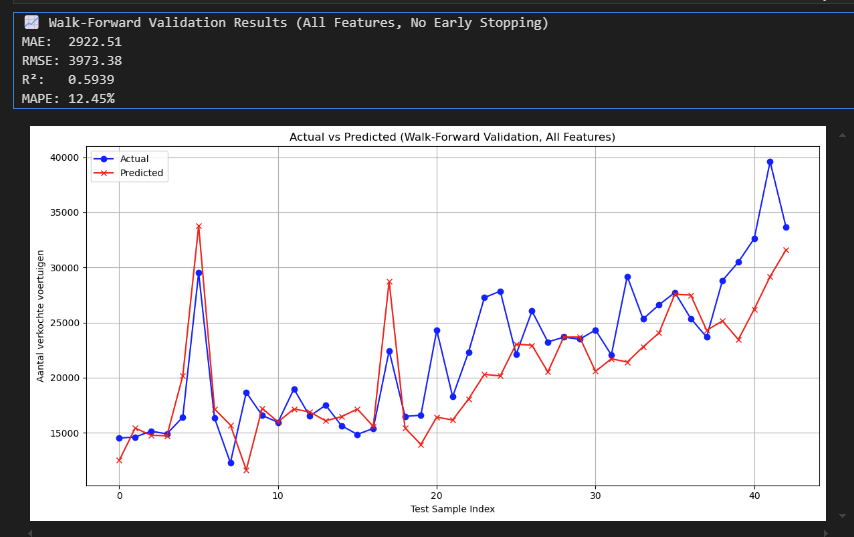